In [1]:
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from imutils.video import VideoStream
from imutils.video import FPS
from matplotlib import pyplot as plt

In [2]:
input_video_path = "videos/car_chase_01.mp4"
output_video_path = "output/car_chase_01.avi"
yolo_directory = "yolo-coco"
# minimum confidence sore
CONFIDENCE = 0.5
# threshold for max supression
THRESHOLD = 0.3

In [3]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([yolo_directory, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

In [4]:
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLOURS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [5]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([yolo_directory, "yolov3.weights"])
configPath = os.path.sep.join([yolo_directory, "yolov3.cfg"])


In [6]:
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
# ln = net.getLayerNames()
outputLayers = [net.getLayerNames()[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(input_video_path)
writer = None
(W, H) = (None, None)

In [7]:
# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1


[INFO] 350 total frames in video


In [8]:
# initialize the video stream, allow the cammera sensor to warmup,
# and initialize the FPS counter
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)
fps = FPS().start()



[INFO] starting video stream...


In [9]:
while True:
    frame = vs.read()

    frame = imutils.resize(frame, width=400)

    (H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)

    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(outputLayers)
    end = time.time()

    # initialize our lists of detected bounding boxes, confidences,
    # and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    # loop over each of the 3 layer output layers
    for output in layerOutputs:
		# loop over each detection for each output layer
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > CONFIDENCE:
                # scale the bounding box coordinates back relative to
                # the size of the image, keeping in mind that YOLO
                # actually returns the center (x, y)-coordinates of
                # the bounding box followed by the boxes' width and
                # height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top
                # and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates,
                # confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
                # apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE,THRESHOLD)

	# ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the frame
            color = [int(c) for c in COLOURS[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]],
                confidences[i])
            cv2.putText(frame, text, (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    
    
   # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
    # update the FPS counter
    fps.update()
    
    
# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] elapsed time: 49.30
[INFO] approx. FPS: 1.54


In [ ]:
layerOutputs[0][0][5:].shape

In [ ]:
for blah in layerOutputs:
    for hehe in blah:
        print(hehe.shape)


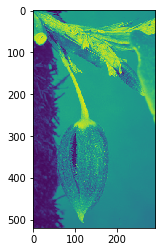

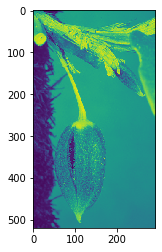

In [10]:
imgL = cv2.imread('images/leftStereo.jpg',0)
imgR = cv2.imread('images/rightStereo.jpg',0)


plt.imshow(imgL)
plt.show()
plt.imshow(imgR)
plt.show()

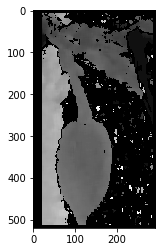

In [11]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()
